# Введение библиотек, обозначение пути, загрузка данных

In [1]:
import os
RAW_DATA_DIR = 'C:/Users/Admin/Desktop/sber'
PRO_DATA_DIR = 'products'
PRODUCTS_DIR = os.path.join(RAW_DATA_DIR, PRO_DATA_DIR)

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
from matplotlib import pyplot as plt
pd.options.display.max_rows = 999
pd.options.display.max_columns = 1000
pd.set_option("expand_frame_repr", True)

orders = pd.read_csv(os.path.join(RAW_DATA_DIR, "kaggle_tab_1345", "tab_1_orders.csv"))
# объединение продуктов
products0 = pd.read_csv(os.path.join(PRODUCTS_DIR, "sbermarket_tab_2_4\\tab_2_products_2020-06-19.csv"))   
numeric_columns = {col: "Int32" if products0[col].dtype == "int64" else "float32" if products0[col].dtype == "float64" else products0[col].dtype for col in products0.columns}

products = pd.DataFrame()

for directory in os.listdir(PRODUCTS_DIR):
    for path in os.listdir(os.path.join(PRODUCTS_DIR, directory)):
        products = pd.concat([products, (pd.read_csv(os.path.join(PRODUCTS_DIR, directory, path))).astype(numeric_columns)])
products = products.astype(numeric_columns)

product_properties = pd.read_csv(os.path.join(RAW_DATA_DIR, "kaggle_tab_1345", "tab_5_product_properties.csv"))
categories = pd.read_csv(os.path.join(RAW_DATA_DIR, "kaggle_tab_1345", "tab_3_categories.csv"))
city = pd.read_csv(os.path.join(RAW_DATA_DIR, "kaggle_tab_1345", "tab_6_city.csv"))

# Удаление простого мусора и проверка

## Продукты

In [3]:
products["brand_name"] = products["brand_name"].replace(["Без бренда",'-','No brand'], np.nan)
products = products.dropna(subset=['price', 'discount', 'quantity', 'product_name'])
products = products[products['price']>0]
products = products[products['quantity']>0]
products = products[products['discount']>=0]
# проверка
[products.isna().sum(),
len(products[products["price"] <= 0]),
len(products[products["quantity"] <= 0]),
len(products[products["discount"] < 0])]

[user_id                     0
 order_id                    0
 line_item_id                0
 price                       0
 quantity                    0
 discount                    0
 product_name                0
 product_id                  0
 brand_name            7693091
 master_category_id      10797
 parent_category_id          0
 dtype: int64,
 0,
 0,
 0]

## Свойства продуктов

In [4]:
product_properties.isna().sum(axis=0)

product_id        0
property_name     0
property_value    1
dtype: int64

In [5]:
product_properties[product_properties['property_value'].isna()]

,product_id,property_name,property_value
644240,84195,ingredients,NaN


In [6]:
# состав не может быть пустым
product_properties = product_properties.dropna(subset=['property_value'])

# Заказы

In [7]:
orders["platform"] = orders["platform"].replace("undefined", np.nan)
orders.isna().sum(axis=0)

user_id                   0
order_id                  0
order_created_time        0
retailer                  0
store_id                  0
platform              76536
dtype: int64

## Удаление пробелов в названиях

In [8]:
def ohne_probel(text):
    try:
        words = text.split()
        words = ' '.join(words)
        return words
    except AttributeError:
        return text

In [9]:
products['brand_name']=products['brand_name'].apply(ohne_probel)
products['product_name']=products['product_name'].apply(ohne_probel)
product_properties['property_name']=product_properties['property_name'].apply(ohne_probel)
product_properties['property_value']=product_properties['property_value'].apply(ohne_probel)
orders['retailer']=orders['retailer'].apply(ohne_probel)

# Очистка пользователей B2B

In [10]:
# введем столбец (количество) * (цена) = (полная стоимость товара)
sumprice = (products['quantity']*products['price']).rename("sumprice") # полная стоимость товара
products.insert(5, "Sumprice", sumprice, True)

## Найдем общую стоимость каждого заказа

In [11]:
sum_order = products.groupby(["order_id"])["Sumprice"].sum()

<AxesSubplot:>

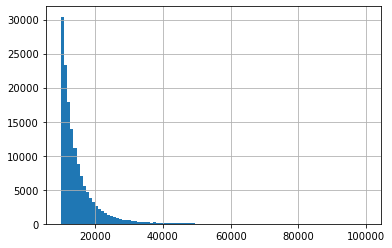

In [12]:
sum_order[(100000>sum_order)&(10000<sum_order)].hist(bins =100)

Видно, что это почти непрерывная экспонента, правильнее всего оборвать тогда, когда заканчивается непрерывность.

<AxesSubplot:>

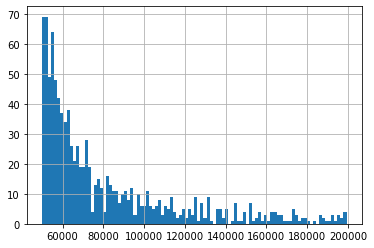

In [13]:
sum_order[(200000>sum_order)&(50000<sum_order) ].hist(bins =100)

Возьму ограничение в 80к на общую стоимость заказа

In [14]:
delete = sum_order[(80000<sum_order)].index.get_level_values('order_id')

In [15]:
products = products[~products["order_id"].isin(delete)]

# Фильтры
Но все равно некоторые товары очевидно куплены не для личного пользования - 100 пачек кофе, например

Посмотрев на график зависимости количества одинаковых товаров от их суммарной стоимости, я пришел к выводу использования 4 фильтров:

1) 1 или 2 товара могут быть любой стоимости

2) Суммарная стоимость любого количества товаров не больше 1000

3) почти все продукты находятся под прямой (количество)/40 + (суммарная цена)/10000 = 1

4) питьевые жидкости и кормы для животных под прямой (количество)/80 + (суммарная цена)/15000) = 1

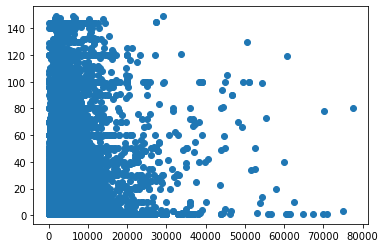

In [16]:
#на графике не указаны точки с количеством больше 150, для наглядности
# до применения фильтров:
prod = products[(products['quantity']<150)]
plt.scatter(prod['Sumprice'], prod['quantity'])

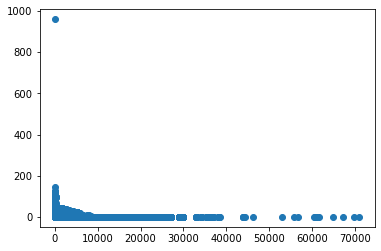

In [17]:
# после применения фильтров:
pr = products[(products['quantity'] <= 2) | ((products['Sumprice']<140) | (products['quantity']/30 + products['Sumprice']/7500 <1) | (((products['parent_category_id']==345)|(products['parent_category_id']==74))&((products['quantity']/50+products['Sumprice']/10000)<1)))]
plt.scatter(pr['Sumprice'], pr['quantity'])
#на графике не указаны точки с количеством больше 45, для наглядности

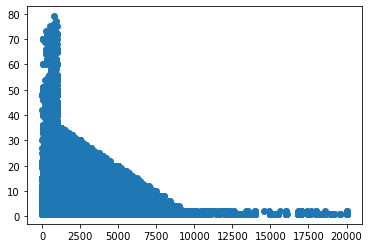

In [18]:
# так выглядят очищенные данные
delete1 = products[(products['quantity'] > 2) & (products['Sumprice']>1000) & ((products['quantity']/40 + products['Sumprice']/10000 > 1) | (((products['parent_category_id']==345)|(products['parent_category_id']==74))&((products['quantity']/80+products['Sumprice']/15000)>1)))]
products = products[(~products["user_id"].isin(delete1['user_id'].values))&(products['quantity']<80)&(products['Sumprice']<20000)]
plt.scatter(products['Sumprice'], products['quantity'])

## Найдем потраченные деньги каждым пользователем и разделим на интервал покупок

In [19]:
orders["order_created_time"] = pd.to_datetime(orders["order_created_time"])
maxtime = orders.groupby(["user_id"])["order_created_time"].max()
mintime = orders.groupby(["user_id"])["order_created_time"].min()
differtime = (maxtime-mintime)
products = products.merge(differtime, on="user_id", how="inner")
products["order_created_time"] = (products["order_created_time"]/(8.64*10**13))+7

TypeError: cannot astype a timedelta from [timedelta64[ns]] to [int32]

In [ ]:
sum_user_all = products.groupby(["user_id"])["Sumprice"].sum().rename("sum_user")

In [ ]:
sum_user = products["Sumprice"] / products["order_created_time"] 

In [ ]:
sum_user[(10000>sum_user)&(100<sum_user) ].hist(bins =100)

Видно, что это почти непрерывная экспонента

In [ ]:
sum_user[(10000>sum_user)&(1000<sum_user) ].hist(bins =100)

обрежу на 2к в день

In [ ]:
products = products[~products["user_id"].isin(sum_user[(2000<sum_user)].index)]

In [ ]:
# нужно удалить введенный столбец Sumprice
products = products.drop(['Sumprice'], axis=1)

# Добавить в тестовые данные колонки `store_id`.

In [21]:
user_stores = pd.read_csv(os.path.join(RAW_DATA_DIR, "user_stores.csv"))
sample_submission = pd.read_csv(os.path.join(RAW_DATA_DIR, "sample_submission.csv"))

In [22]:
sample_submission.rename(columns={'Id': 'user_id'}, inplace=True)

In [ ]:
sample_submission = sample_submission.merge(user_stores, on ='user_id', how="inner")

In [ ]:
sample_submission.to_csv(os.path.join(RAW_DATA_DIR, "sample_submission_output.csv"), index=False)
products.to_csv(os.path.join(RAW_DATA_DIR, "products.csv"), index=False)

# Проверка холодного старта

In [23]:
sample_submission['user_id'].isin(products['user_id']).sum()

100907